In [2]:

import json, random, time, os, base64
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import pickle


In [3]:
dataset = json.load(open("/content/drive/MyDrive/WebQA_train_val.json", "r"))

print(Counter([dataset[k]['split'] for k in dataset]))
print(len(set([dataset[k]['Guid'] for k in dataset])))
print(Counter([dataset[k]['Qcate'] for k in dataset]))

Counter({'train': 36766, 'val': 4966})
41732
Counter({'text': 20267, 'YesNo': 7320, 'Others': 5412, 'choose': 4220, 'number': 2118, 'color': 1830, 'shape': 565})


In [4]:
### Txt-based queries
show_distractors = True

while True:
    k = random.choice(list(dataset.keys()))
    if dataset[k]['Qcate'] == 'text': break

print(k)
print("Q = ", dataset[k]['Q'])
print("\nA =")
pprint(dataset[k]['A'])
print("\n------ Positive Evidence ------ ")
for f in dataset[k]['txt_posFacts']:
    print(f['fact'])
    print(f['url'])

if show_distractors:
    print("\n------ Negative Evidence ------ ")
    for f in dataset[k]['txt_negFacts']:
        print(f['fact'])
        print(f['url'])

d5d5e5900dba11ecb1e81171463288e9
Q =  Distoleon tetragrammicus is a species of what that is a group of about 2,000 species of insects?

A =
['antlion']

------ Positive Evidence ------ 
This article is about the insect. For other uses, see Antlion (disambiguation). The antlions are a group of about 2,000 species of insect in the family Myrmeleontidae, known for the fiercely predatory habits of their larvae, which in many species dig pits to trap passing ants or other prey.
https://en.wikipedia.org/wiki/Antlion
Distoleon tetragrammicus is a species of antlion in the subfamily Myrmeleontinae. Distoleon tetragrammicus is widespread in the western Palearctic realm and it is present in most of Southern Europe and in North Africa.
https://en.wikipedia.org/wiki/Distoleon_tetragrammicus

------ Negative Evidence ------ 
The adults of Distoleon tetragrammicus appear in the middle of the summer and fly from June to August. They are attracted to light.
https://en.wikipedia.org/wiki/Distoleon_tetr

In [43]:
questions = []
answers = []
positive_snippets = []
negative_snippets = []

i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    questions.append(dataset[k]['Q'].split(" "))
    answers.append(dataset[k]['A'][0].split(" "))
    for positive_evidence in dataset[k]['txt_posFacts']:
      positive_snippets.append(positive_evidence["fact"].split(" "))
    for negative_evidence in dataset[k]['txt_negFacts']:
      negative_snippets.append(negative_evidence["fact"].split(" "))
    i+=1
    # if i ==100:
    #   break


In [44]:
training_data = questions+answers+positive_snippets+negative_snippets

In [45]:
len(training_data)

378171

In [ ]:
#train the w2v model
model = Word2Vec(sentences = training_data, size = 600, window = 5, min_count =1 , workers = 8)

In [54]:
model.save("/content/drive/MyDrive/mmmlx/word2vec_trained.model_rerun")

In [3]:
model = Word2Vec.load("/content/drive/MyDrive/mmmlx/word2vec_trained.model")

In [37]:
print(len(vector))
len(model.wv.vocab)

600


6150

In [7]:
model.most_similar("graphical")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('interface', 0.8651276230812073),
 ('modulation', 0.8565418124198914),
 ('probabilistic', 0.8535658121109009),
 ('3D', 0.8505091667175293),
 ('hardware', 0.8494466543197632),
 ('computational', 0.8423826694488525),
 ('desktop', 0.8423376083374023),
 ('wiki', 0.8422976136207581),
 ('next-generation', 0.8416270017623901),
 ('software.', 0.8401882648468018)]

In [ ]:
#TSNE code

In [8]:
questions_vectors = []
answers_vectors = []

i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    v = []
    for word in dataset[k]['Q'].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    questions_vectors.append(v)
    i+=1
    # if i ==2:
    #   break
questions_vectors = np.array(questions_vectors)

In [72]:
questions_vectors.shape

(20267, 600)

In [11]:
from sklearn.manifold import TSNE
# questions_tsnse = TSNE(n_components=2).fit_transform(questions_vectors)


In [11]:
import seaborn as sns
import pandas as pd

# Visualize using true label
df_plot = pd.DataFrame([questions_tsnse[:, 0], questions_tsnse[:, 1]]).T
df_plot.columns = ['1st_dim', '2nd_dim']
sns.scatterplot(x='1st_dim', y='2nd_dim',data=df_plot, legend="full")

In [12]:
answers_vectors = []

i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    v = []
    for word in dataset[k]['A'][0].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    answers_vectors.append(v)
    i+=1
    # if i ==2:
    #   break
answers_vectors = np.array(answers_vectors)
# answers_tsnse = TSNE(n_components=2).fit_transform(answers_vectors)


In [ ]:
#TSNE model for both the questions and answers
qa_vectors = np.vstack((questions_vectors, answers_vectors))
qa_tsne =  TSNE(n_components=2).fit_transform(qa_vectors)

In [ ]:
qa_vectors.shape

In [ ]:
df_plot2 = pd.DataFrame([answers_tsnse[:, 0], answers_tsnse[:, 1]]).T
df_plot2.columns = ['1st_dim', '2nd_dim']
sns.scatterplot(x='1st_dim', y='2nd_dim',data=df_plot2, legend="full")

In [23]:
positive_vectors = []
negative_vectors = []
evidence_label = []
i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    flag = 0
    for evidence in dataset[k]['txt_posFacts']:
      v = []
      flag+=1
      for word in evidence["fact"].split(" "):
        v.append(model.wv[word])
      v = np.array(v)
      v = np.mean(v, axis =0)
      positive_vectors.append(v)
      evidence_label.append(1)
      if flag == 2:
        flag = 0
        break

    v = []
    flag = 0
    for evidence in dataset[k]['txt_negFacts']:
      v = []
      flag +=1
      for word in evidence["fact"].split(" "):
        v.append(model.wv[word])
      v = np.array(v)
      v= np.mean(v, axis =0)
      negative_vectors.append(v)
      evidence_label.append(-1)
      if flag == 2:
        break

    i += 1
    if i==300:
      break

snippet_vectors = np.vstack((np.array(positive_vectors), np.array(negative_vectors)))

In [24]:
snippet_vectors.shape

(1200, 600)

In [25]:
qa_tsne =  TSNE(n_components=2).fit_transform(snippet_vectors)

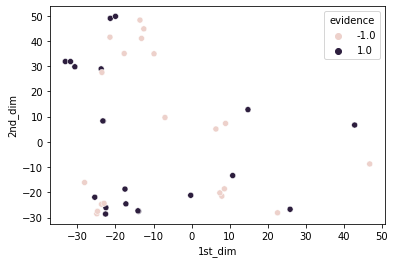

In [83]:
#tsne visualization of positive and negative sources together

df_plot_qa = pd.DataFrame([qa_tsne[:40, 0], qa_tsne[:40, 1], evidence_label[:]]).T
df_plot_qa.columns = ['1st_dim', '2nd_dim', "evidence"]
sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'evidence', data=df_plot_qa, legend="full")

Positive Evidences Plot

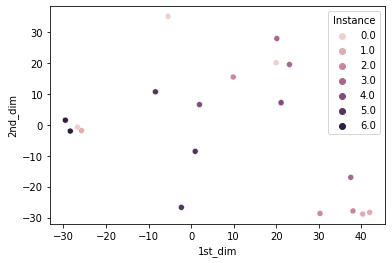

In [36]:
positive_vectors = []
negative_vectors = []
instance_label = []
i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    flag = 0
    for evidence in dataset[k]['txt_posFacts']:
      v = []
      flag+=1
      for word in evidence["fact"].split(" "):
        v.append(model.wv[word])
      v = np.array(v)
      v = np.mean(v, axis =0)
      positive_vectors.append(v)
      instance_label.append(i)
      if flag == 2:
        flag = 0
        break

    v = []
    flag = 0
    for evidence in dataset[k]['txt_negFacts']:
      v = []
      flag +=1
      for word in evidence["fact"].split(" "):
        v.append(model.wv[word])
      v = np.array(v)
      v= np.mean(v, axis =0)
      negative_vectors.append(v)
      instance_label.append(i)
      if flag == 1:
        break

    i += 1
    if i==300:
      break

pos_vectors = np.vstack((np.array(positive_vectors), np.array(negative_vectors)))
pos_tsne =  TSNE(n_components=2).fit_transform(pos_vectors)
df_plot_pos = pd.DataFrame([pos_tsne[:20, 0], pos_tsne[:20, 1], instance_label[:20]]).T
df_plot_pos.columns = ['1st_dim', '2nd_dim', "Instance"]
sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'Instance', data=df_plot_pos, legend="full")


Plot only 2 positive sources per question

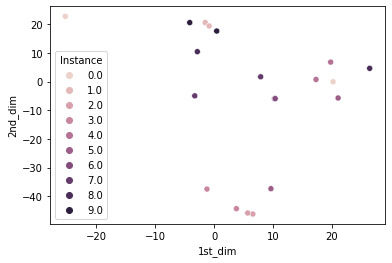

In [82]:
positive_vectors = []
negative_vectors = []
instance_label = []
i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    flag = 0
    for evidence in dataset[k]['txt_posFacts']:
      v = []
      flag+=1
      for word in evidence["fact"].split(" "):
        v.append(model.wv[word])
      v = np.array(v)
      v = np.mean(v, axis =0)
      positive_vectors.append(v)
      instance_label.append(i)
      # if flag == 2:
      #   flag = 0
      #   break

    i += 1
    if i==300:
      break

pos_vectors = np.array(positive_vectors)
pos_tsne =  TSNE(n_components=2).fit_transform(pos_vectors)
df_plot_pos = pd.DataFrame([pos_tsne[:20, 0], pos_tsne[:20, 1], instance_label[:20]]).T
df_plot_pos.columns = ['1st_dim', '2nd_dim', "Instance"]
sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'Instance', data=df_plot_pos, legend="full")


Question Answer Plot

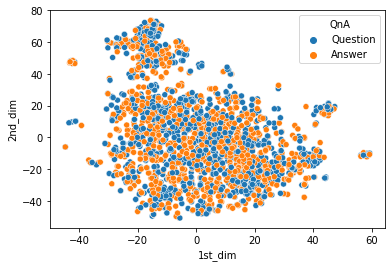

In [42]:
questions_vectors = []
answers_vectors = []
qa_label = []

i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    v = []
    for word in dataset[k]['Q'].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    questions_vectors.append(v)
    qa_label.append("Question")

    v = []
    for word in dataset[k]['A'][0].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    answers_vectors.append(v)
    qa_label.append("Answer")
    i+=1

    if i == 1000:
      break

questions_vectors = np.array(questions_vectors)
answers_vectors = np.array(answers_vectors)
qna_vectors = np.vstack((questions_vectors, answers_vectors))


qna_tsne =  TSNE(n_components=2).fit_transform(qna_vectors)
df_plot_qna = pd.DataFrame([qna_tsne[:, 0], qna_tsne[:, 1], qa_label[:]]).T
df_plot_qna.columns = ['1st_dim', '2nd_dim', "QnA"]
qna_plot = sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'QnA', data=df_plot_qna, legend="full")

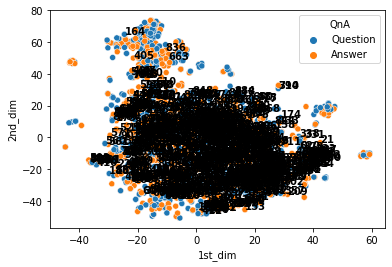

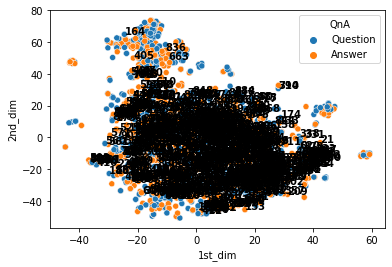

In [78]:
df_plot_qna = pd.DataFrame([qna_tsne[:, 0], qna_tsne[:, 1], qa_label[:]]).T
df_plot_qna.columns = ['1st_dim', '2nd_dim', "QnA"]
qna_plot = sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'QnA', data=df_plot_qna, legend="full")
for instance in range(0,qna_tsne[:900].shape[0]):
  qna_plot.text(qna_tsne[instance,0]+0.01, qna_tsne[instance,1],str(instance),horizontalalignment='left', size='medium', color='black', weight='semibold')

qna_plot.figure

In [ ]:
164, 405, 663
95, 64, 37

In [80]:
questions_vectors = []
answers_vectors = []
qa_label = []

i=0
for k in list(dataset.keys()):
  if dataset[k]['Qcate'] == "text":
    v = []
    for word in dataset[k]['Q'].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    questions_vectors.append(v)
    qa_label.append("Question")

    if i==164 or i==405 or i==663 or i==95 or i == 64 or i==37 or i == 836 or i ==174:
      print(i," " , dataset[k]['Q'])

    i+=1
    v = []
    for word in dataset[k]['A'][0].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    answers_vectors.append(v)
    qa_label.append("Answer")

    if i==164 or i==405 or i==663 or i==95 or i == 64 or i==37 or i == 836 or i==174:
      print(i," " , dataset[k]['A'][0])
    i+=1

    if i == 2000:
      break

questions_vectors = np.array(questions_vectors)
answers_vectors = np.array(answers_vectors)
qna_vectors = np.vstack((questions_vectors, answers_vectors))

37   There are 38 districts in Tamil Nadu, whose state animal is the Nilgiri tahr, which belongs to the genus Nilgiritragus.
64   In what initial way was land in, what is now Great Britain, that was held by the Crown, worked, or made to bear a crop?
95   No, they are not. Mexican population is concentrated mostly in the federal states of Bavaria, Baden-Württemberg while Afro-Germans are in larger cities like Hamburg, Darmstadt, Frankfurt, Munich, Bremen, Cologne and Berlin
164   Is gradient boosting used in GSP algorithm?
174   When you get an allergic response to contact with a substance, what symptom will develop first?
405   Yes
663   Yes, the right gastric artery anastomoses with the left gastric artery and the inferior epigastric vein anastomoses from the superior epigastric vein.
836   Both the corticobular tract and the corticopontine fibres are connected to which cortex?


Computing statistics

In [107]:
from sklearn.metrics.pairwise import cosine_similarity
qa_similarity =[]
pos_pw_similarity = []
pos_neg_similarity = []
i=0
for k in list(dataset.keys()):
  questions_vectors = []
  answers_vectors = []
  positive_vectors = []
  negative_vectors = []
  if dataset[k]['Qcate'] == "text":
    v = []
    for word in dataset[k]['Q'].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    questions_vectors.append(v)

    v = []
    for word in dataset[k]['A'][0].split(" "):
      v.append(model.wv[word])
    v = np.array(v)
    v= np.mean(v, axis =0)
    answers_vectors.append(v)

    for evidence in dataset[k]['txt_posFacts']:
      v = []
      for word in evidence["fact"].split(" "):
        v.append(model.wv[word])
      v = np.array(v)
      v = np.mean(v, axis =0)
      positive_vectors.append(v)

    v = []
    for evidence in dataset[k]['txt_negFacts']:
      v = []
      for word in evidence["fact"].split(" "):
        v.append(model.wv[word])
      v = np.array(v)
      v= np.mean(v, axis =0)
      negative_vectors.append(v)

    #Compute the similarities
    pos_pw_similarity.append(cosine_similarity(np.array(positive_vectors)).mean())
    pos_neg_similarity.append(cosine_similarity(np.array(positive_vectors), np.array(negative_vectors)).mean())
    qa_similarity.append(cosine_similarity(np.array(questions_vectors), np.array(answers_vectors)).mean())


    i+=1

  if i == 10000:
    break

print(pos_pw_similarity)
print(pos_neg_similarity)
print(qa_similarity)


[0.8606897, 0.9735705, 0.9592171, 0.9620177, 0.8966317, 0.89254606, 0.99082965, 0.9280599, 0.9058541, 0.9688333, 0.92598283, 0.9470933, 0.96897066, 0.96128535, 0.912652, 0.7789732, 0.8922366, 0.9350746, 0.97913325, 0.8891152, 0.9473319, 0.94316983, 0.9205084, 0.91341096, 0.93519133, 0.9120408, 0.8141933, 0.9653176, 0.9104881, 0.9213582, 0.9728636, 0.94714963, 0.8032546, 0.92470807, 0.94818866, 0.87532973, 0.9498104, 0.93977475, 0.94029784, 0.88869536, 0.9522096, 0.88813156, 0.9401021, 0.9336479, 0.9624357, 0.88052857, 0.88901794, 0.90331066, 0.8180342, 0.9498441, 0.965307, 0.9222926, 0.92849386, 0.9587579, 0.9423602, 0.96792865, 0.93456376, 0.9004007, 0.93598807, 0.95883864, 0.93856496, 0.89624184, 0.96733785, 0.90626395, 0.94357026, 0.86914706, 0.88431644, 0.93694836, 0.95598793, 0.96620136, 0.89427173, 0.92082834, 0.9438039, 0.90463287, 0.88300157, 0.92041767, 0.9430819, 0.89906263, 0.9547706, 0.9336742, 0.90000474, 0.96646416, 0.94640315, 0.8738125, 0.8923362, 0.87305593, 0.9483944,

In [108]:
pos_pw_similarity_mean = np.array(pos_pw_similarity).mean()
pos_neg_similarity_mean = np.array(pos_neg_similarity).mean()
qa_similarity_mean  = np.array(qa_similarity).mean()
print(pos_pw_similarity_mean,pos_neg_similarity_mean,qa_similarity_mean )

0.92068166 0.8075563 0.5210086


In [105]:
np.array(qa_similarity).mean()

0.5938329

In [100]:
np.array(pos_neg_similarity).mean()

0.71060455